## ASSIGNMENT 2 - The Secrets of Optical Flow
                                                                                            Name: Kushal Shah
                                                                                            Roll No: 2021202027

### Importing necessary libraries for the assignment
- OpenCV
- Numpy
- Matplotlib

### Environment
- Python 3

## 1. Basics of Optical Flow

### 1.1 Thought Experiments

##### Q1 The number-one use of optical flow in visual effects is for retiming a sequence — speeding it up or slowing it down. Describe how optical flow could be used to create slow motion video.


**Answer:-**
    To create a slow-motion video, we need to add additional frames in the video which contain information that is not present in the input video. To produce a smooth video, we need to do interpolation of 2 consecutive frames. Interpolation estimates intermediate position of the objects between 2 consecutive frames. To calculate these intermediate positions, we need to get the optical flow of moving pixels and with the help of optical flow, we can create new intermediate frames to add the frames to the original video and slow down the video. Slowing video will work without interpolation as well but the resulting video will not be smooth. The slow-motion video made with interpolation will be smoother. 

##### Q2 In the Matrix, one of the most remembered, iconic use of the tactic comes during the rooftop scene where Neo effortlessly dodges one bullet after another. (Re-)watch “Bullet Time” here and explain briefly how optical flow is used. You may also find this amazing video on bullet-time interesting.


**Answer: -** 
    The ‘Bullet Time’ scene in the Matrix is a perfect example of slow-motion video. We can get slow-motion video by 2 methods. 
    - Capture more frames for the shot that is to be shown in slow motion 
    - Create and add frames using interpolation with help of optical flow. 

The 1st method is discussed in detail in the second video of ‘bullet time’ where they have shown the method to create slow-motion videos using many cameras capturing the same scene one after another with very small delay. 

The 2nd method can be implemented using interpolation. We need to calculate optical flow of the bullet, then we can add more frames by slowing down the speed of the bullet in the video.  

When we combine both methods, we can get slow-motion video as shown in the Matrix movie of ‘Bullet Time’. Several cameras are used to get a 360-degree view of the shot and all the videos from these cameras are slowed down to create the iconic shot of ‘Bullet Time’. While adding additional frames, we also need to take a video of the actor performing the different actions to dodge the bullet which can easily be done either by superimposing a separate shot of the actor performing the dodge actions or by using extrapolation of frames of the actor by calculating optical flow for the actor in the same shot as the bullet. 

Thus, with the help of optical flow and several cameras, we can re-create the bullet time scene. 

##### Q3  So breathtaking, heartbreaking and brimming with emotion, WDMC is a journey into the afterlife and deals with a dead man’s attempt to reunite with his wife. Catch a glimpse of the ”Painted World” here! You’ll now describe briefly on how optical flow is used to create this “painterly effect”.

**Answer: -** 
    In the painterly effect, the colors are flowing through the scene with help of optical flow. The optical flow of each color is calculated, and the color objects are moved through the frames using the optical flow and keeping the previous frame pixels the same. The painterly effect is created by keeping the colors of the previous frames persistent for a further few frames to make it look like a stroke of paintbrush where colors are spreading which is done using optical flow.

##### Q4 Consider a Lambertian ball that is: (i) rotating about its axis in 3D under constant illumination and (ii) stationary and a moving light source. What does the 2D motion field and optical flow look like in both cases.

**Answer: -** 
    In the first case, we will not be able to identify the optical flow due to the lack of good features to detect the optical flow (considering Lambertian ball to be smooth). In this case, we cannot identify the moving pixels due to smoothness hence even though the ball is moving we cannot get the optical flow. We have 2d motion field but no optical flow in this case 
    In 2nd case if the light source is moving and the Lambertian ball is fixed then we can get the optical flow from the changing pixel values of the shadow of the Lambertian ball. Hence, we can calculate the optical flow. Thus, we get the optical flow of the ball, and it seems like the ball is rotating in the shot even though it is stationary, and the light source is moving. We don’t have 2d motion field but there is optical flow in this case. 

### 1.2 Concept Review 

##### Q1 List down the important assumptions made in optical flow estimation. Describe each one of them in one-two lines. 

**Answer: -** 
The important assumptions made in optical flow estimation are as follows: 

- It assumes that the flow is essentially smooth in a local neighborhood of the pixel under consideration – The assumption is based on the consideration that pixels in a small window have a similar flow and tend to follow it. Hence, we get similar intensity values over the small window of pixels 

- It assumes that the neighboring pixels under consideration have the same displacement - The assumption is based on the consideration that pixels in a small window usually follow the similar displacement and hence the movement of the pixels under considerations in consecutive frames over a window will generally give the similar optical flow.  

##### Q2 Formalize the objective function of the classical optical flow problem. Clearly mark the data term and the spatial term. What does the objective function imply about the noise distribution? 

**Answer: -**

In optical flow we assume that the surrounding patch (say 5x5) has constant flow. It means that the intensities of the surrounding pixels in a small window is constant. We can formally write the objective function as 

Ixu + Iyv + It = 0 

Where Ix = dI/dx and Iy = dI/dy which are the partial derivatives of intensities in x and y directions. These are the spatial terms in calculating optical flow 

It is the temporal term where It = dI/dt which is the partial derivative of intensity with respect to time. 

We need to apply Gaussian blur to reduce the noise distribution in the image before calculating optical flow. The objective function does not include noise distribution term in it hence we need to pre-process the image before applying the objective function. 

##### Q3 In optimization, why is the first-order Taylor series approximation done? 

**Answer: -** 

In optical flow we have brightness constancy assumption which states that intensity of the pixels for a particular small window remains constant over time. 

f(x,y,t) = f(x+dx, y+dy, t+dt) (where x, y are pixel value at x, y and t is the temporal dimension)  

We can apply the Taylor series approximation on the above equation since the change is very small. The higher-order terms of the Taylor series approximation become very close to 0 hence they are ignored. Thus, we remain with only first-order terms of the Taylor series approximation. With the help of this optimization, we only consider the change in intensity rather than the intensity values in each consecutive frame. 

#### Q4 Geometrically show how the optical flow constraint equation is ill-posed. Also, draw the normal flow clearly.

**Answer: -**

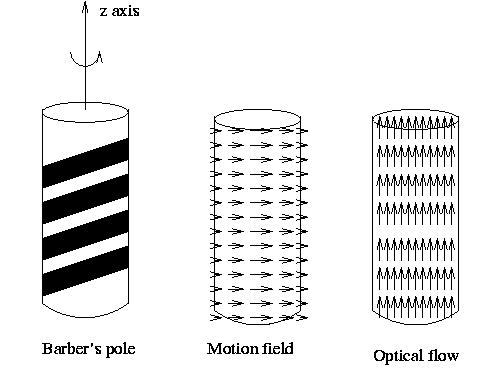

When we try to get an optical flow for the edges of some patterns then it miscalculates the optical flow. As shown in the above diagram, a Barber’s pole moves horizontally, and the motion field is in the X direction, but the calculated optical flow is in the Z direction. This happens because while getting the optical flow we are only concerned with the pixels that move in consecutive frames. We are unable to get the whole picture due to the Aperture problem.

## 2. Single-Scale Lucas-Kanade Optical Flow 

In [422]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig

### 2.1. Keypoint Selection: Selecting Pixels to Track

**Helper Functions**

In [423]:
def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

UNKNOWN_FLOW_THRESH = 1e7

def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

In [424]:
def framesToVideo(path,fps,total_frames,extension,output_path,start_frame,sop_num):
    i=start_frame
    frame_list=[]
    while i < (total_frames+start_frame):
        if i<10 and sop_num:
            frame_list.append(cv2.imread(path + '0' + str(i) + extension))
        else:
            frame_list.append(cv2.imread(path + str(i) + extension))
        i=i+1
    height,width,layer = frame_list[0].shape
    size = (width,height)
    video = cv2.VideoWriter(output_path + '.avi',cv2.VideoWriter_fourcc(*'DIVX'),fps,size)
    i = 0
    while i<total_frames:
        video.write(frame_list[i])
        i=i+1
    video.release()
    cv2.destroyAllWindows()

In [418]:
def show_image(img,title):
    plt.title(title)
    plt.imshow(img)
    plt.show()
    
def show_image_from_source(img,title):
    img_ori = cv2.imread(img)
    plt.title(title)
    plt.imshow(img_ori)
    plt.show()
    
def plot_images(img_vec,titles,rows,cols,fig_size=(15,15)):
    fig = plt.figure(figsize=fig_size) 
    for idx,item in enumerate(img_vec):
        ax = fig.add_subplot(rows,cols,idx+1)
        ax.axis('off')
        ax.imshow(item)
        ax.set_title(titles[idx])
#         ax.axis('off')

    plt.show()
    
def save_images(img_vec,path):
    it = 0
    for i in img_vec:
        plt.imshow(i)
        save_path = path + 'frame{0}.jpg'.format(it)
        plt.savefig(save_path, dpi=200,transparent=True)
        plt.clf()
        it = it + 1


**2.1.1 Harris Corner Detector**

Algorithm:
1. Take the grayscale of the original image
2. Apply a Gaussian filter to smooth out any noise
3. Apply Sobel operator to find the x and y gradient values for every pixel in the grayscale image
4. For each pixel p in the grayscale image, consider a 3×3 window around it and compute the corner strength function. Call this its Harris value.
5. Find all pixels that exceed a certain threshold and are the local maxima within a certain window (to prevent redundant dupes of features)
6. For each pixel that meets the criteria in 5, compute a feature descriptor.

In [226]:
# Sobel x-axis kernel
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

def img_to_gray_normalized(img):
    img_ori = cv2.imread(img)
    gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
    gray  = gray/255.0
    return gray

def convolve(img):
    
#     RGB Image to Gray image
    gray = img_to_gray_normalized(img)
    
#     Sobel operators to compute I_x and I_y
    I_x = sig.convolve2d(gray, SOBEL_X, mode='same')
    I_y = sig.convolve2d(gray, SOBEL_Y, mode='same')
    
    I_x2 = np.square(I_x)
    I_y2 = np.square(I_y)
    I_xy = I_x*I_y
    
#     Guassian blur to smoothen the image
    I_x2 = sig.convolve2d(I_x2, GAUSS, mode='same')
    I_y2 = sig.convolve2d(I_y2, GAUSS, mode='same')
    I_xy = sig.convolve2d(I_xy, GAUSS, mode='same')
    
    return I_x2,I_y2,I_xy

In [227]:
def harris_corner(img, threshold):
    I_x2,I_y2,I_xy = convolve(img)
    img_ori = cv2.imread(img)
    
#     determinant
    det = I_x2 * I_y2 - I_xy ** 2
#     trace
    trace = I_x2 + I_y2
    
    k = 0.06
    harris_R = det - k * trace ** 2

#     nonmax supression
    points = np.where(harris_R >= threshold)
#     drawing filtered points
    for pt in zip(*points[::-1]):
        img_ori = cv2.circle(img_ori, pt, 3, (255, 0, 0), -1)
    
#     show_image(img_ori,"Harris")
#     plt.plot(harris_R, c='hotpink')
    return img_ori

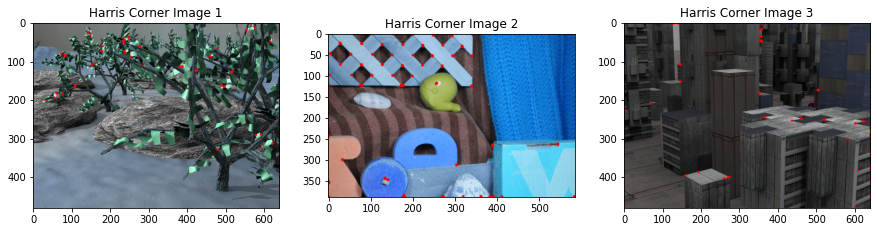

In [301]:
img_t1 = '../data/all-frames-colour/Grove3/frame07.png'
img_t2 = '../data/all-frames-colour/RubberWhale/frame07.png'
img_t3 = '../data/all-frames-colour/Urban2/frame07.png'
harris_img1 = harris_corner(img_t1,3)
harris_img2 = harris_corner(img_t2,0.15)
harris_img3 = harris_corner(img_t3,0.08)
plot_images([harris_img1,harris_img2,harris_img3],["Harris Corner Grove","Harris Corner Rubber Whale","Harris Corner Urban"],2,3)

Here we have to manually set the threshold value for the harris corner detector. Corners are detected for all 3 types of images given as input. We have used sobel filters to get derivatives in x and y directions. The window size is 3x3. We have used Guassian blur filter to smoothen the image and reduce the noise. We have normalized the images between 0-1. The threshold values are determined manually by plotting a graph of harris_R score. With the help of plot we can estimate a good threshold value.

**2.1.2 Shi-Tomasi Corner Detector**

Algorithm:
1. Take the grayscale of the original image
2. Apply a Gaussian filter to smooth out any noise
3. Apply Sobel operator to find the x and y gradient values for every pixel in the grayscale image
4. For each pixel p in the grayscale image, consider a 3×3 window around it and get the eigen values of the 2x2 matrix formed using derivates of I_x I_y and I_xy
5. Find all pixels whose smallest eigen value exceed a certain threshold and are the local maxima within a certain window (to prevent redundant dupes of features)
6. For each pixel that meets the criteria in 5, compute a feature descriptor.

In [228]:
def shi_tomasi(img,threshold):
    I_x2,I_y2,I_xy = convolve(img)
    img_ori = cv2.imread(img)
    
    shi_tomasi_R = np.zeros((I_x2.shape))
    
    #     determinant
    det = I_x2 * I_y2 - I_xy**2
    det_cp = np.where(det > 0)
    
    for pt in range(det_cp[0].shape[0]): 
        i = det_cp[0][pt]
        j = det_cp[1][pt]
        A = np.array([[I_x2[i][j],I_xy[i][j]],[I_xy[i][j],I_y2[i][j]]])
        val,vec = np.linalg.eig(A)
        val = np.sort(val)
        if val[0]>threshold:
            shi_tomasi_R[i][j] = val[0]

#     nonmax supression
    points = np.where(shi_tomasi_R >= threshold)
#     drawing filtered points
    for pt in zip(*points[::-1]):
        img_ori = cv2.circle(img_ori, pt, 3, (255, 0, 0), -1)
    
#     show_image(img_ori,"Shi-Tomsai")
#     plt.plot(shi_tomasi_R,c = 'hotpink')
    return img_ori

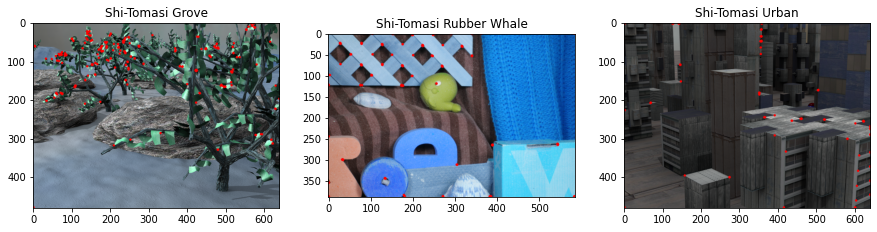

In [304]:
shi_tomasi_img1 = shi_tomasi(img_t1,1)
shi_tomasi_img2 = shi_tomasi(img_t2,0.34)
shi_tomasi_img3 = shi_tomasi(img_t3,0.2)
plot_images([shi_tomasi_img1,shi_tomasi_img2,shi_tomasi_img3],["Shi-Tomasi Grove","Shi-Tomasi Rubber Whale","Shi-Tomasi Urban"],2,3)

Here we have to manually set the threshold value for the shi-tomasi corner detector. Corners are detected for all 3 types of images given as input. We have used sobel filters to get derivatives in x and y directions. The window size is 3x3. We have used Guassian blur filter to smoothen the image and reduce the noise. We have normalized the images between 0-1. The threshold values are determined manually by plotting a graph of shi-tomasi-R score. With the help of plot we can estimate a good threshold value.

### 2.2 Forward-Additive Sparse Optical Flow

**Lukas Kanade**

Algorithm:
1. Take the grayscale of the original images
2. Normalize both the images
3. Calculate I_x, I_y and I_t of the images using masks
4. For each pixel p if determinant is not 0 then get the eigen values of A matrix
5. If least eigen value is greater than the threshold then calculate u and v vectors using A matrix and I_t
6. For each pixel that meets the criteria in 5, plot a quiver plot.

In [229]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, threshold):
    gray1 = img_to_gray_normalized(Img1)
    gray2 = img_to_gray_normalized(Img2)
    
    Mask_X = np.array((
    [-1, 1],
    [-1, 1]), dtype="float64")
    
    Mask_Y = np.array((
    [-1, -1],
    [1, 1]), dtype="float64")
    
    Mask_t1 = np.array((
    [-1, -1],
    [-1, -1]), dtype="float64")
    
    Mask_t2 = np.array((
    [1, 1],
    [1, 1]), dtype="float64")

#     Convoluting Both Frames with masks
    gray1_x = sig.convolve2d(gray1, Mask_X, mode='same')
    gray1_y = sig.convolve2d(gray1, Mask_Y, mode='same')
    gray1_t = sig.convolve2d(gray1, Mask_t1, mode='same')
    
    gray2_x = sig.convolve2d(gray2, Mask_X, mode='same')
    gray2_y = sig.convolve2d(gray2, Mask_Y, mode='same')
    gray2_t = sig.convolve2d(gray2, Mask_t2, mode='same')
    
#     Getting I_x, I_y and I_t from both frames combines
    I_x = (gray1_x + gray2_x)/2
    I_y = (gray1_y + gray2_y)/2
    I_t = gray1_t + gray2_t
        
    
    fin_con_x = np.square(I_x)
    fin_con_y = np.square(I_y)
    fin_con_xy = I_x*I_y
    fin_con_xt = I_x*I_t
    fin_con_yt = I_y*I_t
    
#     Getting sum of all matrix values in a particular window by sliding the window with convolution operation 
    convolve_filter = np.ones(windowSize)
    
    I_x2 = sig.convolve2d(fin_con_x, convolve_filter, mode='same')
    I_y2 = sig.convolve2d(fin_con_y, convolve_filter, mode='same')
    I_xy = sig.convolve2d(fin_con_xy, convolve_filter, mode='same')
    I_xt = sig.convolve2d(fin_con_xt, convolve_filter, mode='same')
    I_yt = sig.convolve2d(fin_con_yt, convolve_filter, mode='same')
    
#     determinant
    det = I_x2 * I_y2 - I_xy**2
    det_cp = np.where(det > 0)
    
    u = np.zeros((gray1.shape))
    v = np.zeros((gray1.shape))
    
    for pt in range(det_cp[0].shape[0]): 
        i = det_cp[0][pt]
        j = det_cp[1][pt]
        A = np.array([[I_x2[i][j],I_xy[i][j]],[I_xy[i][j],I_y2[i][j]]])
        val,vec = np.linalg.eig(A)
        val = np.sort(val)
        if val[0]>threshold:
            A_inv = np.linalg.inv(A)
            At_B_x = -1*I_xt[i][j]
            At_B_y = -1*I_yt[i][j]
            At_B = np.array([[At_B_x],[At_B_y]])
            U_cal = np.dot(A_inv,At_B)
            u[i][j] = U_cal[0]
            v[i][j] = U_cal[1]
    return u,v 

In [399]:
def compute_vector_distance(pts,min_dist):
    fin_list = []
    for k in range(pts[0].shape[0]):
        should_inc = True
        for j in range(len(fin_list)):
            if not should_inc:
                break
            if abs(pts[0][k] - fin_list[j][0]) < min_dist and abs(pts[1][k]- fin_list[j][1]) < min_dist:
                should_inc = False
        if should_inc:
            fin_list.append([pts[0][k],pts[1][k]])
    return fin_list
    
def quiver_plot(img1,u,v,threshold,min_dist,path):
    img_temp = cv2.imread(img1)
    fin_vec = np.absolute(u) + np.absolute(v)
    pts = np.where(fin_vec>threshold)
    fin_list = compute_vector_distance(pts,min_dist)
    plt.imshow(img_temp)
    for i in range(len(fin_list)):
        x = fin_list[i][0]
        y = fin_list[i][1]
        plt.quiver(y,x,u[x][y],v[x][y], color = "red")
    plt.savefig(path, dpi=200,transparent=True)
#     plt.show()
    plt.clf()

def avg_epe(u_flow,v_flow,folder):
    act_flow = read_flow('../data/ground-truth-flow/' + folder + '/flow10.flo')
    error_val = 0
    u_pts = np.where(u_flow!=0)
    v_pts = np.where(v_flow!=0)
    
    u_val = act_flow[:,:,0]
    v_val = act_flow[:,:,1]
    
    for i in range(u_pts[0].shape[0]):
        x = u_pts[0][i]
        y = u_pts[1][i]
        u_val[x,y] = u_flow[x,y] - u_val[x,y]
        
    for i in range(v_pts[0].shape[0]):
        x = v_pts[0][i]
        y = v_pts[1][i]
        v_val[x,y] = v_flow[x,y] - v_val[x,y]
        
    error_val = np.sum(np.sqrt(np.square(u_val) + np.square(v_val)))/(u_flow.shape[0]*u_flow.shape[1])
    return error_val
    

In [404]:
folders = ['Grove3','RubberWhale','Urban2']
quiver_thresholds = [40,7,35]
# folders = ['Grove3']
itr = 0
for i in folders:
    frames_flow = []
    u_flow = []
    v_flow = []
    path = '../data/all-frames-colour/' + i + '/frame'
    output_path = '../results/LK/' + i + '/' + i
    framesToVideo(path,2,8,'.png',output_path,7,True)
    windowSize = (5,5)
    threshold = 1e-2
    save_path_base = '../results/LK/' + i
    quiver_threshold = quiver_thresholds[itr]
    for j in range(7,14):
        if j<10:
            img1 = path + '0' + str(j) + '.png'
        else:
            img1 = path + str(j) + '.png'
        if (j+1) < 10:
            img2 = path + '0' + str(j+1) + '.png'
        else:
            img2 = path + str(j+1) + '.png'
        u,v = LukasKanadeForwardAdditive(img1,img2,windowSize,threshold)
        
        plt.clf()
        save_path = save_path_base + '/quiver/frame' + str(j-7) + '.jpg' 
        quiver_plot(img1,u,v,quiver_threshold,25,save_path)
        plt.clf()
        
        u_flow.append(u.astype(int))
        v_flow.append(v.astype(int))
        frames_flow.append(compute_color(u,v).astype(int))
        
    save_path = save_path_base + '/u_direction/'
    save_images(u_flow,save_path)
    
    save_path = save_path_base + '/v_direction/'
    save_images(v_flow,save_path)
    
    save_path = save_path_base + '/flow/'
    save_images(frames_flow,save_path)
    itr = itr + 1

<Figure size 432x288 with 0 Axes>

In [405]:
folders = ['Grove3','RubberWhale','Urban2']
for i in folders:
    base_path = '../results/LK/' + i + '/'
    sub_folders = ['quiver','flow','u_direction','v_direction']
    for j in sub_folders: 
        path = base_path + j + '/'
        actual_path = path + 'frame'
        output_path = path + 'vid'
        framesToVideo(actual_path,2,7,'.jpg',output_path,0,False)

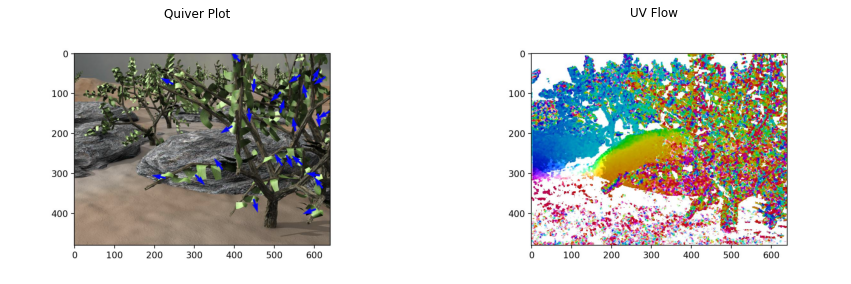

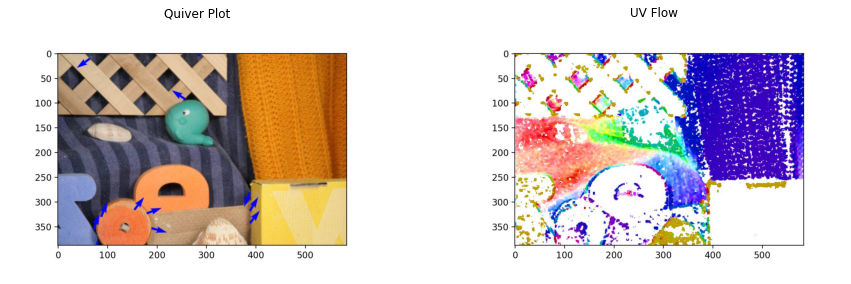

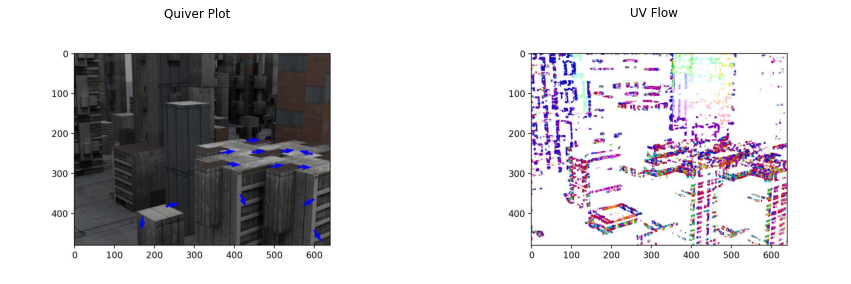

In [419]:
folders = ['Grove3','RubberWhale','Urban2']
for i in folders:
    img_vec = []
    titles = ['Quiver Plot','UV Flow']
    base_path = '../results/LK/' + i + '/'
    sub_folders = ['quiver','flow']
    for j in sub_folders: 
        path = base_path + j + '/frame0.jpg'
        img_vec.append(cv2.imread(path))
    plot_images(img_vec,titles,2,2)

The results for all type of images are stored in the results/LK/ folder. There are quiver frames, uv flow frames, u-direction frames and v-direction frames for all types of given input images. All the frames are compiled in a video and stored in their corresponding folders. Quiver plot is also compilled and stored in the quiver folder of each image type.

**Assumptions & Observations:**
Here we are going from dense to sparse Lukas Kanade. We are calculating u and v vectors for only those pixels which are above the given threshold. We calculate optical flow only at good features (windows having corners). The threshold ensures that the optical flow will be calculated only at those points where the A\`A matrix is invertible.
After getting the optical flow we plot the quiver plot and superimpose on the images. Here we can visualize UV flow and quiver plots. The quivers are drawn at the corners in the images and show the direction where that particular window containing the corner moves in the next frame. The quivers give a approximate direction of the optical flow.

#### Average End Point Errors (EPE)

In [407]:
folders = ['Grove3','Urban2']
for i in folders:
    img1 = '../data/all-frames-colour/' + i + '/frame10.png'
    img2 = '../data/all-frames-colour/' + i + '/frame11.png'
    windowSize = (5,5)
    threshold = 1e-2
    u,v = LukasKanadeForwardAdditive(img1,img2,windowSize,threshold)
    print('Average EPE for {0} type images is {1}\n'.format(i,avg_epe(u,v,i)))

Average EPE for Grove3 type images is 5.21146240234375

Average EPE for Urban2 type images is 8.704829915364583



EPE error for the above images is as shown above. The normal Forward Additive Lucas Kanade gives approximate positions for the optical flow hence there is more EPE error for these images

### 2.3 Analyzing Lucas-Kanade Method

######  Q1 Why is optical flow only valid in the regions where local structure-tensor ATA has a rank 2? What role does the threshold τ play here? 

**Answer: -** 

The rank 2 tensors are needed because we need to get 2 eigenvalues of the matrix which are directly proportional to the change in x and y direction. These eigenvalues are similar to the Harris corner detector where the smallest eigenvalue must be greater than some threshold value. If the matrix is rank 1 then the number of linearly independent rows or columns is only 1. This means we can identify the change in only 1 direction which represents an edge. But optical flow on edges is not accurate hence we need the matrix to have rank 2 so it can have 2 linearly independent rows or columns which help to identify the change in both the directions. 

The threshold helps to identify the corners or features which can be easily tracked. The threshold defines the pixels for which optical flow is calculated. The smallest Eigen value of the ATA matrix must be greater or equal to the threshold to calculate the optical flow. With the help of the threshold, we can go from dense optical flow to calculating only sparse optical flow. 

##### Q2 In the experiments, did you use any modifications and/or thresholds? Does this algorithm work well for these test images? If not, why? 
**Answer: -** 

The threshold determines the number of pixels where we can calculate the optical flow. The threshold value is inversely proportional to the number of pixels where we get the optical flow. The algorithm works well for certain test images but misidentifies corners and good features for other test images. This might be due to the presence of noise which misleads the algorithm to think that it has encountered a corner even if there is no corner. We can improve the performance by using Gaussian Smoothing which will reduce the noise for images. 

##### Q3 Try experimenting with different window sizes. What are the trade-offs associated with using a small versus a large window size? Can you explain what’s happening? 

**Answer: -** 

In small window size, we get more accurate results on a minute level where there is very little change in the consecutive frames while in large window size, we can identify large motion changes. There is a tradeoff between getting accurate results or identifying the large changes. As the window size increases, the accuracy of the change might decrease but we can identify a larger motion due to the presence of a larger window.  

##### Q4 There are locations in an image where Lucas–Kanade optical flow will fail, regardless of choice of window size and sigma for Gaussian smoothing. Describe two such situations.You are not required to demonstrate them.  

**Answer: -** 

The Lucas Kanade fails at following situations 

1. Large Movement: When the change in consecutive frames is more than the window size then the algorithm is not able to detect the optical flow for these situations 

2. Diagonal Motion: The algorithm is not able to determine the diagonal motion of the edges due to aperture problem. Eg. Barber pole problem for optical flow where we cannot detect motion field of barber pole as shown in 1st part.  

 

##### Q5 Did you observe that the ground truth visualizations are in HSV colour space? Try to reason it. 

**Answer: -** 

In HSV color, V represents the brightness of the image. We have assumed that the brightness remains constant for a small window size in Lucas Kanade. The HSV color space represents these changes more accurately with the help of different brightness levels representing which of the parts are moving in the image. Hence HSV is more suitable to show the optical flow of consecutive frames. 

## 3 Multi-Scale Coarse-to-fine Optical Flow

**Algorithm**
1. Gaussian smooth and scale Img1 and Img2 by a factor of 2ˆ(1 - numLevels).
2. Compute the optical flow at this resolution.
3. For each level,
    - Scale Img1 and Img2 by a factor of 2ˆ(1 - level)
    - Upscale the previous layer‘s optical flow by a factor of 2
    - Compute u and v by calling OpticalFlowRefine with the previous level‘s optical flow

In [408]:
def OpticalFlowRefine(Img1, Img2, windowSize, threshold, u0, v0):
    gray1 = Img1
    gray2 = Img2

#     gray1 = img_to_gray_normalized(Img1)
#     gray2 = img_to_gray_normalized(Img2)
    
    Mask_X = np.array((
    [-1, 1],
    [-1, 1]), dtype="float64")
    
    Mask_Y = np.array((
    [-1, -1],
    [1, 1]), dtype="float64")
    
    Mask_t1 = np.array((
    [-1, -1],
    [-1, -1]), dtype="float64")
    
    Mask_t2 = np.array((
    [1, 1],
    [1, 1]), dtype="float64")
    
    u_m = int(np.amax(np.absolute(u0)))
    v_m = int(np.amax(np.absolute(v0)))

#     Convoluting Both Frames with masks
    gray1_x = sig.convolve2d(gray1, Mask_X, mode='same')
    gray1_y = sig.convolve2d(gray1, Mask_Y, mode='same')
    gray1_t = sig.convolve2d(gray1, Mask_t1, mode='same')
    
    gray2 = cv2.copyMakeBorder(gray2, int(abs(v_m)), int(abs(v_m)), int(abs(u_m)), int(abs(u_m)), cv2.BORDER_CONSTANT, None, value = 0)
    
    gray2_x = sig.convolve2d(gray2, Mask_X, mode='same')
    gray2_y = sig.convolve2d(gray2, Mask_Y, mode='same')
    gray2_t = sig.convolve2d(gray2, Mask_t2, mode='same')

#     Getting I_x, I_y and I_t from both frames combines
    I_x = np.zeros((gray1.shape))
    I_y = np.zeros((gray1.shape))
    I_t = np.zeros((gray1.shape))
    
    for i in range(gray1.shape[0]):
        for j in range(gray1.shape[1]):
            I_x[i][j] = (gray1_x[i][j] + gray2_x[v_m+int(u0[i][j])][u_m+int(v0[i][j])])/2
            I_y[i][j] = (gray1_y[i][j] + gray2_y[v_m+int(u0[i][j])][u_m+int(v0[i][j])])/2
            I_t[i][j] = gray1_t[i][j] + gray2_t[v_m+int(u0[i][j])][u_m+int(v0[i][j])]
    
      
    fin_con_x = np.square(I_x)
    fin_con_y = np.square(I_y)
    fin_con_xy = I_x*I_y
    fin_con_xt = I_x*I_t
    fin_con_yt = I_y*I_t
    
#     Getting sum of all matrix values in a particular window by sliding the window with convolution operation 
    convolve_filter = np.ones(windowSize)
    
    I_x2 = sig.convolve2d(fin_con_x, convolve_filter, mode='same')
    I_y2 = sig.convolve2d(fin_con_y, convolve_filter, mode='same')
    I_xy = sig.convolve2d(fin_con_xy, convolve_filter, mode='same')
    I_xt = sig.convolve2d(fin_con_xt, convolve_filter, mode='same')
    I_yt = sig.convolve2d(fin_con_yt, convolve_filter, mode='same')
    
#     determinant
    det = I_x2 * I_y2 - I_xy**2
    det_cp = np.where(det > 0)
    
    u = np.zeros((gray1.shape))
    v = np.zeros((gray1.shape))
    
    for pt in range(det_cp[0].shape[0]): 
        i = det_cp[0][pt]
        j = det_cp[1][pt]
        A = np.array([[I_x2[i][j],I_xy[i][j]],[I_xy[i][j],I_y2[i][j]]])
        val,vec = np.linalg.eig(A)
        val = np.sort(val)
        if val[0]>threshold:
            A_inv = np.linalg.inv(A)
            At_B_x = -1*I_xt[i][j]
            At_B_y = -1*I_yt[i][j]
            At_B = np.array([[At_B_x],[At_B_y]])
            U_cal = np.dot(A_inv,At_B)
            u[i][j] = U_cal[0]
            v[i][j] = U_cal[1]
    return u,v 

In [409]:
def downSample(Img):
    down_img = cv2.GaussianBlur(Img, (5,5), cv2.BORDER_DEFAULT)
    return down_img[::2, ::2]

def upSample(Img):
    out = np.zeros( (2)*np.array(Img.shape),dtype=Img.dtype)
    out[::2,::2] = Img
    return out

def MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels,threshold):
    
    img1_path = Img1
    img2_path = Img2
    
    Img1 = img_to_gray_normalized(Img1)
    Img2 = img_to_gray_normalized(Img2)
    
    Img1_pyr = np.zeros((Img1.shape[0],Img1.shape[1],numLevels))
    Img2_pyr = np.zeros((Img1.shape[0],Img1.shape[1],numLevels))
    
    Img1_pyr[:,:,0] = Img1
    Img2_pyr[:,:,0] = Img2
    
    prev_shape = Img1.shape
    
    pyr_shapes=[]
    pyr_shapes.append(prev_shape)
    
    for i in range(1,numLevels):
        next_shape = (int(prev_shape[0]/2),int(prev_shape[1]/2))
        Img1_pyr[:next_shape[0],:next_shape[1],i] = downSample(Img1_pyr[:prev_shape[0],:prev_shape[1],i-1])
        Img2_pyr[:next_shape[0],:next_shape[1],i] = downSample(Img2_pyr[:prev_shape[0],:prev_shape[1],i-1])
        prev_shape = next_shape
        pyr_shapes.append(prev_shape)
        
    u_ini,v_ini = LukasKanadeForwardAdditive(img1_path,img2_path,windowSize,threshold)
    at_most_scale = 2**(numLevels-1)
    u_ini = u_ini[::at_most_scale, ::at_most_scale]
    v_ini = v_ini[::at_most_scale, ::at_most_scale]
    for i in range(numLevels-1,0,-1):
        curr_shape = pyr_shapes[i]
        u_ini,v_ini = OpticalFlowRefine(Img1_pyr[:curr_shape[0],:curr_shape[1],i],Img2_pyr[:curr_shape[0],:curr_shape[1],i],windowSize,threshold,u_ini,v_ini)
        if i != 0:
            u_ini = upSample(u_ini)
            v_ini = upSample(v_ini)
    return u_ini,v_ini
    

In [412]:
folders = ['Grove3','RubberWhale','Urban2']
quiver_thresholds = [40,50,35]
# folders = ['Grove3']
itr = 0
for i in folders:
    frames_flow = []
    u_flow = []
    v_flow = []
    path = '../data/all-frames-colour/' + i + '/frame'
    output_path = '../results/Multi-Scale_LK/' + i + '/' + i
    framesToVideo(path,2,8,'.png',output_path,7,True)
    windowSize = (5,5)
    threshold = 1e-2
    save_path_base = '../results/Multi-Scale_LK/' + i
    quiver_threshold = quiver_thresholds[itr]
    numLevels = 3
    for j in range(7,14):
        if j<10:
            img1 = path + '0' + str(j) + '.png'
        else:
            img1 = path + str(j) + '.png'
        if (j+1) < 10:
            img2 = path + '0' + str(j+1) + '.png'
        else:
            img2 = path + str(j+1) + '.png'
        u,v = MultiScaleLucasKanade(img1,img2,windowSize,numLevels,threshold)
        
        plt.clf()
        save_path = save_path_base + '/quiver/frame' + str(j-7) + '.jpg' 
        quiver_plot(img1,u,v,quiver_threshold,25,save_path)
        plt.clf()
        
        u_flow.append(u.astype(int))
        v_flow.append(v.astype(int))
        frames_flow.append(compute_color(u,v).astype(int))
        
    save_path = save_path_base + '/u_direction/'
    save_images(u_flow,save_path)
    
    save_path = save_path_base + '/v_direction/'
    save_images(v_flow,save_path)
    
    save_path = save_path_base + '/flow/'
    save_images(frames_flow,save_path)
    itr = itr + 1

<Figure size 432x288 with 0 Axes>

In [413]:
folders = ['Grove3','RubberWhale','Urban2']
for i in folders:
    base_path = '../results/Multi-Scale_LK/' + i + '/'
    sub_folders = ['quiver','flow','u_direction','v_direction']
    for j in sub_folders: 
        path = base_path + j + '/'
        actual_path = path + 'frame'
        output_path = path + 'vid'
        framesToVideo(actual_path,2,7,'.jpg',output_path,0,False)

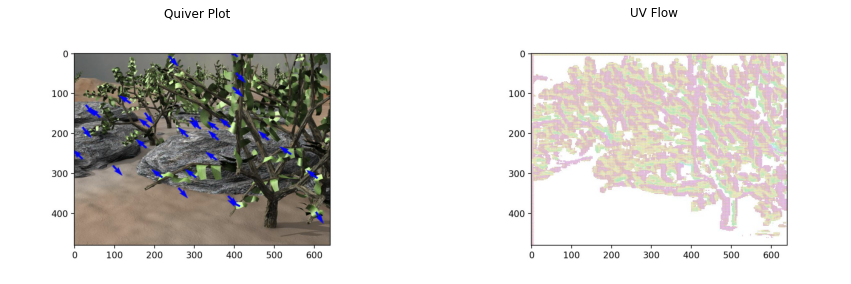

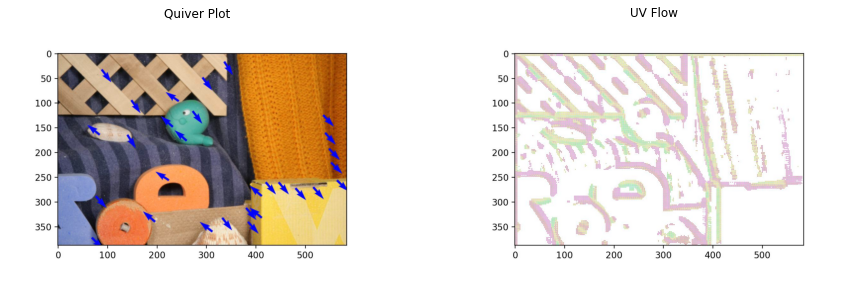

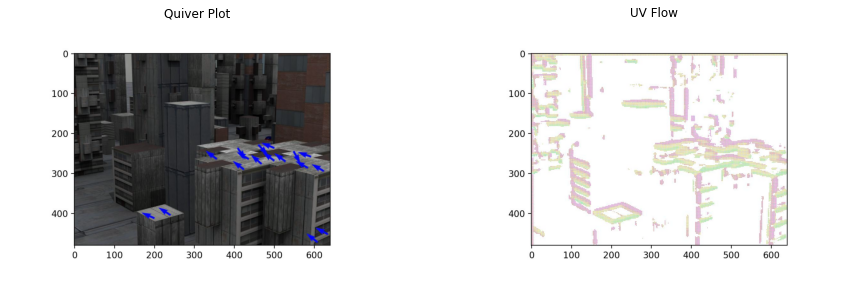

In [420]:
folders = ['Grove3','RubberWhale','Urban2']
for i in folders:
    img_vec = []
    titles = ['Quiver Plot','UV Flow']
    base_path = '../results/Multi-Scale_LK/' + i + '/'
    sub_folders = ['quiver','flow']
    for j in sub_folders: 
        path = base_path + j + '/frame0.jpg'
        img_vec.append(cv2.imread(path))
    plot_images(img_vec,titles,2,2)

The results for all type of images are stored in the results/Multi-Scale_LK/ folder. There are quiver frames, uv flow frames, u-direction frames and v-direction frames for all types of given input images. All the frames are compiled in a video and stored in their corresponding folders. Quiver plot is also compilled and stored in the quiver folder of each image type.

**Assumptions & Observations:**
Here we use pyramid scheme to downscale the original image and then calculate the optical flow. Downscaling helps to find the larger motion within consecutive frames since the window size remains the same but the image is downscaled. Multi-Scale Lucas Kanade gives more accurate optical flow of the objects since it can identify general motion of the objects. Using Multi-Scale Lucas Kanade we can get optical flow even for the objects having large motion outside of the window.

After getting the optical flow we plot the quiver plot and superimpose on the images. Here we can visualize UV flow and quiver plots. The quivers are drawn at the corners in the images and show the direction where that particular window containing the corner moves in the next frame. The quivers give a approximate direction of the optical flow.

#### Average End Point Errors (EPE)

In [425]:
folders = ['Grove3','Urban2']
for i in folders:
    img1 = '../data/all-frames-colour/' + i + '/frame10.png'
    img2 = '../data/all-frames-colour/' + i + '/frame11.png'
    windowSize = (5,5)
    threshold = 1e-2
    numLevels = 3
    u_multi,v_multi = MultiScaleLucasKanade(img1,img2,windowSize,numLevels,threshold)
    print('Average EPE for {0} type images is {1}\n'.format(i,avg_epe(u_multi,v_multi,i)))

Average EPE for Grove3 type images is 4.551573486328125

Average EPE for Urban2 type images is 8.374795735677083



EPE error for the above images is as shown above. The Multi-Scale Lucas Kanade gives a little less average EPE compared to Forward Additive Lucas Kanade. This shows that Multi-Scale Lucas Kanade performs better than normal Lucas Kanade and can get more accurate optical flow values

We can see that Multi-Scale Lukas Kanade works well for Grove3 images. In simple Lucas Kanade we were getting a vague direction of the movement of the leaves in quiver plot but in the Multi-Scale Lukas Kanade, we get more accurate representation of the optical flow of the leaves. This is due to the fact the Multi-Scale Lukas Kanade works on a pyramid like structure which gets the more general direction of the optical flow in loer resolution of the images.